<a href="https://colab.research.google.com/github/ArjunSohur/ArjunSohur/blob/main/BERT_notebooks/Stopwords_cleaned_BERT_attention_no_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attention is essentially how much a model "pays attention to" certain words, which reveals their importance.  In this program, I am trying to visualize and come up with a method to determine which sentences are more important than others.

In [76]:
pip install transformers

In [ ]:
pip install seaborn

In [78]:
pip install matplotlib

In [79]:
pip install nltk

In [ ]:
pip install sklearn

In [437]:
# Importing libraries for usage
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler

from nltk.corpus import stopwords
nltk.download('stopwords')

import pandas as pd

import re
import matplotlib.colors as mcolors

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# BERT is a transformer based model
# https://en.wikipedia.org/wiki/BERT_(language_model)
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(model_name, output_attentions=True)

# A tokenizer splits the text into tokens, which is how the BERT model understands words
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Rerun for testing purposes

In [660]:
text = "Earlier in the day, the Boulder weather service office warned that “We are still in the 'loaded gun' scenario of having tremendous instability,” which could lead to severe weather throughout the evening."

print(text)

Earlier in the day, the Boulder weather service office warned that “We are still in the 'loaded gun' scenario of having tremendous instability,” which could lead to severe weather throughout the evening.


In [661]:
# 0 as False 1 as True
# I was messing around to see if the results were better if there wasn't punctuation
# It turns out, the model performs better when there is (based on qualitative tests)
remove_punc = 1
remove_stop = 1

In [662]:
# Defining a primitave punctuation removal method
def remove_punctuation(text):
    # Not perfect, but a small catch function; does not handle edge cases, but gets rid of those chars
    punctuation_marks = r'[.,;:\'-]'

    # Replace the punctuation marks with an empty string using regex (re.sub)
    processed_text = re.sub(punctuation_marks, '', text)

    return processed_text

def remove_stopwords(text):
    words = nltk.word_tokenize(text)

    stopwords_list = set(stopwords.words("english"))

    other_stopwords = ["said", "told", "says"]

    stopwords_list.update(other_stopwords)

    filtered_words = [word for word in words if word.lower() not in stopwords_list]

    filtered_sentence = " ".join(filtered_words)

    return filtered_sentence


In [663]:
# Calling the function to
if remove_stop:
  text = remove_stopwords(text)

if remove_punc:
  text = remove_punctuation(text)

if remove_stop:
  text = remove_stopwords(text)

print(text)

Earlier day Boulder weather service office warned “ still loaded gun scenario tremendous instability ” could lead severe weather throughout evening


In [664]:
inputs = tokenizer.encode_plus(text, add_special_tokens=False, return_tensors="pt")
input_ids = inputs["input_ids"]
input_ids = torch.cat((torch.tensor([[101]]), input_ids), 1)


print(input_ids)

tensor([[  101,  3041,  2154, 13264,  4633,  2326,  2436,  7420,  1523,  2145,
          8209,  3282, 11967, 14388, 18549,  1524,  2071,  2599,  5729,  4633,
          2802,  3944]])


In [665]:
# These lines of code take the token ids and covert it back to readable language so that I can plot them on the graph
# It uses a lot of library functions
input_ids_list = input_ids.squeeze().tolist()
decoded_tokens = tokenizer.decode(input_ids_list)

tokens = tokenizer.tokenize(decoded_tokens)

In [666]:
# This one line does a lot, but it essentially runs the model
outputs = model(input_ids)

# Attention weights for the last layer
# In python, you can do negatice indexing from the back of a list
attention_weights = outputs.attentions[-1]

In [667]:
# BERT actually has multiple calculation of attention weights, so I'm taking their average here
mean_attention_weights = torch.mean(attention_weights.squeeze(dim=0), dim=0, )

In [668]:
# Normalizing weights for cleaner data
normalized_attention_weights = torch.softmax(mean_attention_weights, dim=1).detach().numpy()

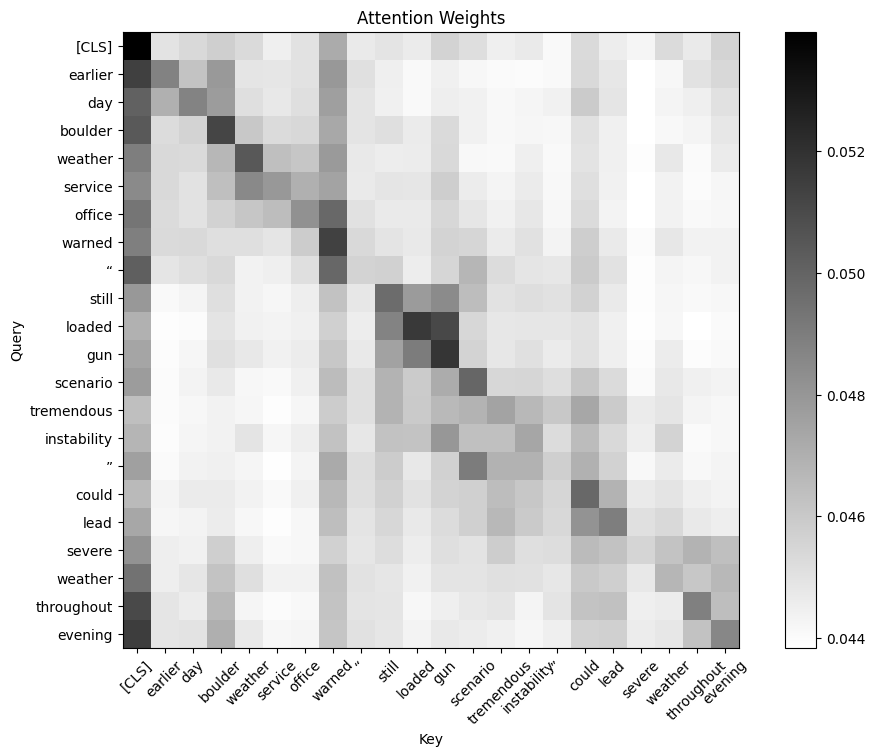

In [669]:
# print graph
colors = ["white", "black"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)

# "tab10"
plt.figure(figsize=(12, 8))
plt.imshow(normalized_attention_weights, cmap=cmap, interpolation="nearest")
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel("Key")
plt.ylabel("Query")
plt.title("Attention Weights")
plt.colorbar()
plt.show()

In [670]:
cls_df = pd.DataFrame(normalized_attention_weights[:][0], index=tokens)

scalar = MinMaxScaler()

cls_df.columns = ["vals"]

cls_df_norm = pd.DataFrame(scaler.fit_transform(cls_df), columns=["vals"], index=tokens)
ordered_cls = cls_df_norm.sort_values("vals", ascending=False)

ordered_cls

,vals
[CLS],1.000000
warned,0.311621
boulder,0.169494
evening,0.154094
gun,0.151842
day,0.130472
could,0.126475
weather,0.124942
weather,0.120672
scenario,0.108510
